In [1]:
# Bibliotecas necessárias para o experimento

import numpy as np, numpy.random
import matplotlib.pyplot as plt
from random import randint
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from random import randint, uniform, random
from scipy.linalg import sqrtm

In [2]:
## CONSTANTES PARA O ALGORITMO GENÉTICO

ELITISMO = True
PORCENTAGEM_ELITISMO = 0.20

TAMANHO_POP = 50
TAXA_MUTACAO = 0.10
TAXA_CRUZAMENTO = 0.70
GERACOES = 100

# Valores mínimos e máximos para gerar uma população
MIN = 0
MAX = 200
 # 115, 150

In [3]:
def S(Ut, Uf, X):
    W = np.dot(np.transpose(Uf), Ut)
    T = np.transpose(W)
    A = np.dot(np.transpose(Ut), np.transpose(X))
    C = np.dot(A, Uf)
    L = W - np.identity(3) - 1/2*(W - np.identity(3))**2
    S = 2*np.trace(np.dot((-np.dot(T, C) + 2*C),L))
    #S = 2*np.trace(np.dot((-1/2*np.dot(C, T) - 1/2*np.dot(T, C) + 2*C),L))
    return S

In [4]:
def field(Ut, Uf, a, h, A, B):
    SA = S(Ut, Uf, A)
    SB = S(Ut, Uf, B)
    f = -a*SA-h*(SB/SA)
    return f

In [5]:
def lind(u, Ut, Uf, t, lbda):
    n = 0.5005
    Ax = [[0, 0, 0],[0, 0, -1], [0, 1, 0]]
    Ay = [[0, 0, 1],[0, 0, 0], [-1, 0, 0]]
    Az = [[0, -1, 0],[1, 0, 0], [0, 0, 0]]
    B = [[(1-n*2)*lbda, 0, 0],[0, (1-n*2)*lbda, 0], [0, 0, (-n*2)*lbda]] # Amplitude Damping
    #B = [[-1.01*lbda, 0, 0],[0, -1.01*lbda, 0], [0, 0, -0.01*lbda]] # Phase Damping
    if t == 0:
        fx = u[0]
        fy = u[1]
        fz = u[2]
        F=np.dot(u[0],Ax)+np.dot(u[1],Ay)+np.dot(u[2],Az)+B
    else:
        fx=field(Ut, Uf, u[0], 0.35, Ax, B)
        fy=field(Ut, Uf, u[1], 0.31, Ay, B)
        fz=field(Ut, Uf, u[2], 0.34, Az, B)
        P=400

        if abs(fx) > P:
            if fx < 0:
                fx = -P
            else:
                fx = P
        if abs(fy) > P:
            if fy < 0:
                fy = -P
            else:
                fy = P
        if abs(fz) > P:
            if fz < 0:
                fz = -P
            else:
                fz = P

        F=np.dot(fx,Ax)+np.dot(fy,Ay)+np.dot(fz,Az)+B
        	
    return fx,fy,fz,F

In [6]:
def rungeKutta(u, Ut, Uf, h, t, lbda):

    if t == 0:
        
        fx,fy,fz,k1 = lind(u, Ut, Uf, t, lbda)
        k1 = np.dot(k1,Ut)
        fx,fy,fz,k2 = lind(u, (Ut+h/2*k1), Uf, t, lbda)
        k2 = np.dot(k2,(Ut+h/2*k1))
        fx,fy,fz,k3 = lind(u, (Ut+h/2*k2), Uf, t, lbda)
        k3 = np.dot(k3,(Ut+h/2*k2))
        fx,fy,fz,k4 = lind(u, (Ut+h*k3), Uf, t, lbda)
        k4 = np.dot(k4,(Ut+h*k3))
        a = fx;
        b = fy;
        c = fz;

    else:

        fx,fy,fz,k1 = lind(u, Ut, Uf, t, lbda)
        k1 = np.dot(k1,Ut)
        fx,fy,fz,k2 = lind(u, (Ut+h/2*k1), Uf, t+h/2, lbda)
        k2 = np.dot(k2,(Ut+h/2*k1))
        fx,fy,fz,k3 = lind(u, (Ut+h/2*k2), Uf, t+h/2, lbda)
        k3 = np.dot(k3,(Ut+h/2*k2))
        fx,fy,fz,k4 = lind(u, (Ut+h*k3), Uf, t+h, lbda)
        k4 = np.dot(k4,(Ut+h*k3))
        a = fx;
        b = fy;
        c = fz;

    
    result = Ut+(h/6)*(k1+2*k2+2*k3+k4);
    return a,b,c,result

In [7]:
def func_objetivo(u, Ut, Uf, h, tempo, lbda):
    a, b, c, Ut1 = rungeKutta(u, Ut, Uf, h, tempo, lbda)
    return (np.linalg.norm(Ut1-Uf))**2

In [8]:
def gerar_populacao():
    populacao = np.zeros((TAMANHO_POP,3))
    for individuo in range(TAMANHO_POP):
        for genes in range(3):
            populacao[individuo,genes] = uniform(MIN, MAX)
    return populacao

In [9]:
def calcular_func(populacao, Ut, Uf, h, tempo, TAMANHO_POP, lbda):
    valor_func = np.zeros(TAMANHO_POP)
    for individuo in range(TAMANHO_POP):
        valor_func[individuo] = func_objetivo(populacao[individuo,:], Ut, Uf, h, tempo, lbda)
    return valor_func

In [10]:
def selecao(valor_fitness):
    pos = np.random.choice(range(TAMANHO_POP), 2, replace=False)
    valor = valor_fitness[pos[0]] < valor_fitness[pos[1]]
    if valor == True:
        return pos[0]
    else:
        return pos[1]

In [11]:
def divisao_fitness(valor_funcao_objetivo):
    divisao = 0
    for i in range(len(valor_funcao_objetivo)):
        divisao += valor_funcao_objetivo[i]
    return divisao

def fitness(valor_funca_objetivo):
    return valor_funca_objetivo/divisao_fitness(valor_funca_objetivo)

In [12]:
def cruzamento(pai1, pai2):
    x = random()
    filho1 = x*pai1+(1-x)*pai2
    filho2 = (1-x)*pai1+x*pai2
    return filho1, filho2

In [13]:
def mutacao(individuo, horizonte):
    
    # Gaussian function
    for i in range (0, horizonte):
        if random() < TAXA_MUTACAO:
            individuo[i] = (1/np.sqrt(2*np.pi))*np.exp((-1/2*(uniform(MIN, MAX)-2)**2))
    
    return individuo

In [14]:
def genetico(Ut, Uf, h, tempo, TAMANHO_POP, lbda):
    
    horizonte = 3
    pop = gerar_populacao()
    fo = calcular_func(pop, Ut, Uf, h, tempo, TAMANHO_POP, lbda)
    fit = fitness(fo)
    fit_edit = fit
    min_fit = min(fit)
            
    melhor_fo = np.zeros(GERACOES)
    for geracao in range(GERACOES):
        new_pop = np.empty((0, horizonte))
        for i in range(round((TAMANHO_POP)/2)):
            pai1 = 0
            pai2 = 0
            while pai1 == pai2:
                pai1 = selecao(fit)
                pai2 = selecao(fit)
            if random() < TAXA_CRUZAMENTO:
                filho1, filho2 = cruzamento(pop[pai1, :], pop[pai2, :])
                filho1 = mutacao(filho1, horizonte)
                filho2 = mutacao(filho2, horizonte)
                new_pop = np.vstack([new_pop, filho1, filho2])
            else:
                pais = np.vstack([mutacao(pop[pai1, :], horizonte), mutacao(pop[pai2, :], horizonte)])
                new_pop = np.vstack([new_pop, pais])
                
        fo = calcular_func(pop, Ut, Uf, h, tempo, TAMANHO_POP, lbda)
        fit = fitness(fo)
        min_fo = min(fo)
        melhor_fo[geracao] = min_fo
        pos_min_fo = np.where(fo == min_fo)
                
    return pop[pos_min_fo,:][0,0]

In [15]:
def leis_controle(fx, fy, fz, quant_pontos, lbda):
    ts = np.linspace(0, 0.1, quant_pontos)

    plt.ylabel("Valores das leis de controle") 
    plt.xlabel('Tempo (u. a.)') 
    plt.plot(ts, fx, color='g', marker='o', linewidth=1, markersize=1, label="$f_x(t)$")
    plt.plot(ts, fy, color='b', marker='_', linewidth=1, markersize=1, label="$f_y(t)$")
    plt.plot(ts, fz, color='r', marker='.', linewidth=1, markersize=1, label="$f_z(t)$")
    plt.legend(loc="upper right")
    plt.title(fr"Leis de controle para $\gamma = {lbda}$")
    plt.show()

In [16]:
def fidelidade(fid, quant_pontos, lbda):
    ts = np.linspace(0, 0.1, quant_pontos)

    fig, ax = plt.subplots()

    ax.set_ylabel("Valores de fidelidade") 
    ax.set_xlabel('Tempo (u. a.)') 
    ax.plot(ts, np.abs(fid), color='g', marker='*', linewidth=1, markersize=1, label=fr"$\gamma = {lbda}$")
    ax.legend(loc="center right")
    ax.set_title(fr"Fidelidade com $\gamma = {lbda}$")

    x1, x2, y1, y2 = 2.5, 4, 0, max(np.abs(fid))
    axins = inset_axes(ax, width="30%", height="30%", loc='upper center', borderpad=3)
    axins.set_xlim(0.009, 0.020)
    axins.set_ylim(0.98, 1)

    axins.plot(ts, np.abs(fid), color='g', marker='*', linewidth=1, markersize=1, label=fr"$\gamma = {lbda}$")
    ax.indicate_inset_zoom(axins)
    
    plt.show()

In [17]:
def distance(fid, quant_pontos, lbda):
    ts = np.linspace(0, 0.1, quant_pontos)

    fig, ax = plt.subplots()

    ax.set_ylabel("Valores de distância") 
    ax.set_xlabel('Tempo (u. a.)') 
    ax.plot(ts, np.abs(fid), color='g', marker='*', linewidth=1, markersize=1, label=fr"$\gamma = {lbda}$")
    ax.legend(loc="center right")
    ax.set_title(fr"Distância entre os operadores de evolução com $\gamma = {lbda}$")

    #x1, x2, y1, y2 = 2.5, 4, 0, max(np.abs(fid))
    #axins = inset_axes(ax, width="30%", height="30%", loc='upper center', borderpad=3)
    #axins.set_xlim(0.009, 0.020)
    #axins.set_ylim(0.98, 1)

    #axins.plot(ts, np.abs(fid), color='g', marker='*', linewidth=1, markersize=1, label=fr"$\gamma = {lbda}$")
    #ax.indicate_inset_zoom(axins)
    
    plt.show()

In [18]:
def densidade(rho, quant_pontos, lbda):
    ts = np.linspace(0, 0.1, quant_pontos)

    fig, ax = plt.subplots()

    ax.set_ylabel('Valores da matriz de densidade') 
    ax.set_xlabel('Tempo (u. a.)') 
    ax.plot(ts, abs(rho[0]), color='g', marker='o', linewidth=1, markersize=1, label=r"$\rho_{00}$")
    ax.plot(ts, abs(rho[1]), color='b', marker='8', linewidth=1, markersize=1, label=r"$\rho_{01}$")
    ax.plot(ts, abs(rho[2]), color='r', marker='.', linewidth=1, markersize=1, label=r"$\rho_{10}$")
    ax.plot(ts, abs(rho[3]), color='y', marker='*', linewidth=1, markersize=1, label=r"$\rho_{11}$")
    ax.legend(loc="center right")
    ax.set_title(fr"Evolução da matriz de densidade $\gamma = {lbda}$")

    x1, x2, y1, y2 = 2.5, 4, 0, max(max(abs(rho[0])), max(abs(rho[1])), max(abs(rho[2])), max(abs(rho[3])))
    axins = inset_axes(ax, width="30%", height="30%", loc='upper center', borderpad=3)
    axins.set_xlim(0.009, 0.020)
    axins.set_ylim(0.98, 1)

    axins.plot(ts, abs(rho[0]), color='g', marker='o', linewidth=1, markersize=1, label=r"$\rho_{00}$")
    axins.plot(ts, abs(rho[1]), color='b', marker='8', linewidth=1, markersize=1, label=r"$\rho_{01}$")
    axins.plot(ts, abs(rho[2]), color='r', marker='.', linewidth=1, markersize=1, label=r"$\rho_{10}$")
    axins.plot(ts, abs(rho[3]), color='y', marker='*', linewidth=1, markersize=1, label=r"$\rho_{11}$")

    ax.indicate_inset_zoom(axins)
    
    plt.show()

In [19]:
def main():
    u = [70, 106, 66, 0.35, 0.31, 0.34] # Hadamard
    
    Ut = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]
    Uf = [[0, 0, 1], [0, -1, 0], [1, 0, 0]] # Hadamard
    
    r0 = [[1], [0], [0]]
    rf = np.dot(Uf, r0)
    pf = [[1/2*(1+rf[2][0]), 1/2*(rf[0][0]-1j*rf[1][0])], [1/2*(rf[0][0]+1j*rf[1][0]), 1/2*(1-rf[2][0])]]
    
    h=0.001
    t=0
    i=0
    lbda=0.01
    # Proposta do algoritmo genético
    resultado_algoritmo_genetico = genetico(Ut, Uf, h, t, TAMANHO_POP, lbda) 
    u[0] = resultado_algoritmo_genetico[0]
    u[1] = resultado_algoritmo_genetico[1]
    u[2] = resultado_algoritmo_genetico[2]
    distance_vector = []
    fx_vector = []
    fy_vector = []
    fz_vector = []
    rho_vector = np.zeros((4,100),dtype=np.complex128)
    fid_vector = []
    fid_autores = []
       
    while t < 100:
        a,b,c,Ut = rungeKutta(u, Ut, Uf, h, t, lbda)
        D = np.linalg.norm(Ut-Uf)**2
        distance_vector.append(D)
        fx_vector.append(a)
        fy_vector.append(b)
        fz_vector.append(c)
        rt = np.dot(Ut, r0)
        pt = [[1/2*(1+rt[2][0]), 1/2*(rt[0][0]-1j*rt[1][0])], [1/2*(rt[0][0]+1j*rt[1][0]), 1/2*(1-rt[2][0])]]
        rho_vector[0][t] = pt[0][0]
        rho_vector[1][t] = pt[0][1]
        rho_vector[2][t] = pt[1][0]
        rho_vector[3][t] = pt[1][1]
        fid_vector.append((np.trace(sqrtm(sqrtm(pt) @ pf @ sqrtm(pt))))**2)
        fid_autores.append((np.trace(np.dot(Ut, np.transpose(Ut)))+np.abs(np.trace(np.dot(np.transpose(Uf), Ut)))**2)/(3*(3+1)))
        resultado_algoritmo_genetico = genetico(Ut, Uf, h, t, TAMANHO_POP, lbda) 
        u[0] = resultado_algoritmo_genetico[0]
        u[1] = resultado_algoritmo_genetico[1]
        u[2] = resultado_algoritmo_genetico[2]
        t += 1
    
    rt = np.dot(Ut, r0)
    pt = [[1/2*(1+rt[2][0]), 1/2*(rt[0][0]-1j*rt[1][0])], [1/2*(rt[0][0]+1j*rt[1][0]), 1/2*(1-rt[2][0])]]
    
    #leis_controle(fx_vector,fy_vector,fz_vector,t,lbda)
    #densidade(rho_vector,t,lbda)
    #fidelidade(fid_vector,t,lbda)
    #fidelidade(fid_autores,t,lbda)
    #distance(distance_vector,t,lbda)

    return fid_vector, fid_autores, rho_vector, distance_vector, fx_vector, fy_vector, fz_vector

In [20]:
portas = []
estados = []
distancia = []

i = 1

fid_vector, fid_autores, rho_vector, distance_vector, fx_vector, fy_vector, fz_vector = main()
portas.append(sum(fid_autores[30:])/(len(fid_autores)-30))
estados.append(sum(fid_vector[30:])/(len(fid_vector)-30))
distancia.append(sum(distance_vector[80:])/(len(distance_vector)-80))

print(f"Valores de média na iteração {i}:")
print(f"Portas: {sum(portas)/i}")
print(f"Estados: {sum(estados)/i}")
print(f"Distância: {sum(distancia)/i}")
print(" ")

Valores de média na iteração 1:
Portas: 0.9986169319248749
Estados: (0.998987060670635+9.085811162992796e-07j)
Distância: 7.692909001071448e-06
 


In [21]:
fid_vector

[np.clongdouble('0.4999996239691714165+0.00020530415656025290284j'),
 np.clongdouble('0.49873743677416977656+0.00014007277724701312354j'),
 np.clongdouble('0.49846494844519922125+0.00019952412383581213714j'),
 np.clongdouble('0.4981868132846300833+0.00010991717556408654039j'),
 np.clongdouble('0.49786309098429941693+0.00030881023370519565492j'),
 np.clongdouble('0.4979505638384619742-1.9354192475251100005e-06j'),
 np.clongdouble('0.49817197506326162026-1.8358340803658823444e-05j'),
 np.clongdouble('0.49812663114626565416+8.5445388130243701153e-13j'),
 np.clongdouble('0.5435177091323190674-1.3705992969208596014e-06j'),
 np.clongdouble('0.5434224408166462619+6.6697633491725106296e-05j'),
 np.clongdouble('0.5433593857220757767-8.819869943801204915e-05j'),
 np.clongdouble('0.6133161836885600962+2.136137582821132907e-08j'),
 np.clongdouble('0.7509426347337120522+5.8067774435501084635e-05j'),
 np.clongdouble('0.86629122163002712564-5.1438611201865980223e-05j'),
 np.clongdouble('0.86630441812

In [22]:
fid_autores

[np.float64(0.33327904355543586),
 np.float64(0.3332899468163841),
 np.float64(0.33328839898888213),
 np.float64(0.33310231985993366),
 np.float64(0.3330983736189071),
 np.float64(0.3330618369724467),
 np.float64(0.327938103839128),
 np.float64(0.32789594292169866),
 np.float64(0.3039543059621646),
 np.float64(0.27020248800687857),
 np.float64(0.2504372584256584),
 np.float64(0.2508028542929058),
 np.float64(0.2762997977191438),
 np.float64(0.33703593234980805),
 np.float64(0.4030091794861977),
 np.float64(0.4962195320852468),
 np.float64(0.5061120966015955),
 np.float64(0.5081392970942086),
 np.float64(0.7190168018927187),
 np.float64(0.7577394629016543),
 np.float64(0.920237568136614),
 np.float64(0.9610849321525424),
 np.float64(0.9611139344211402),
 np.float64(0.9679137427533003),
 np.float64(0.9679199376921499),
 np.float64(0.9693286533446628),
 np.float64(0.9701012524688704),
 np.float64(0.9700949458026763),
 np.float64(0.9853360905974734),
 np.float64(0.9857283185644584),
 np.fl

In [23]:
rho_vector

array([[5.00000000e-01+0.00000000e+00j, 4.98735985e-01+0.00000000e+00j,
        4.98462711e-01+0.00000000e+00j, 4.98180482e-01+0.00000000e+00j,
        4.97863050e-01+0.00000000e+00j, 4.97710769e-01+0.00000000e+00j,
        4.97966350e-01+0.00000000e+00j, 4.97982927e-01+0.00000000e+00j,
        5.43324274e-01+0.00000000e+00j, 5.43164958e-01+0.00000000e+00j,
        5.43165249e-01+0.00000000e+00j, 6.13315888e-01+0.00000000e+00j,
        7.50649188e-01+0.00000000e+00j, 8.66239742e-01+0.00000000e+00j,
        8.66236162e-01+0.00000000e+00j, 9.42093713e-01+0.00000000e+00j,
        9.60492715e-01+0.00000000e+00j, 9.64692969e-01+0.00000000e+00j,
        9.64688372e-01+0.00000000e+00j, 9.85333439e-01+0.00000000e+00j,
        9.85328614e-01+0.00000000e+00j, 9.85323801e-01+0.00000000e+00j,
        9.85318990e-01+0.00000000e+00j, 9.85314179e-01+0.00000000e+00j,
        9.85309368e-01+0.00000000e+00j, 9.85304557e-01+0.00000000e+00j,
        9.85299745e-01+0.00000000e+00j, 9.85294934e-01+0.0000000

In [24]:
sum(distance_vector[30:])/(len(distance_vector)-30)

np.float64(0.005169866034529692)

In [25]:
distance_vector

[np.float64(7.999348422961727),
 np.float64(7.999479262830182),
 np.float64(7.9994606893672735),
 np.float64(7.997225841817775),
 np.float64(7.997178448114345),
 np.float64(7.996739366667489),
 np.float64(7.934282706580791),
 np.float64(7.933761054102434),
 np.float64(7.610040800013554),
 np.float64(6.988074658093344),
 np.float64(6.182422885116399),
 np.float64(5.768173137552738),
 np.float64(4.865689507335774),
 np.float64(3.9481306612172022),
 np.float64(3.282925458621359),
 np.float64(2.5556001694971715),
 np.float64(2.487398591591362),
 np.float64(2.4735280287209065),
 np.float64(1.2492167771205185),
 np.float64(1.0592983702775862),
 np.float64(0.3246979662365217),
 np.float64(0.15820259589886532),
 np.float64(0.15805656321615358),
 np.float64(0.13024460578411437),
 np.float64(0.13019242120001157),
 np.float64(0.12440948904792981),
 np.float64(0.12122800261006839),
 np.float64(0.12122690348297634),
 np.float64(0.059405398189609646),
 np.float64(0.05779433193453862),
 np.float64(0.

In [26]:
fx_vector

[np.float64(0.0),
 np.float64(-0.044171773338697845),
 np.float64(-0.002983040963906676),
 np.float64(-0.020663937620345314),
 np.float64(-0.02079661875593656),
 np.float64(3.954842155472832),
 np.float64(-0.004425555853900699),
 np.float64(-0.00452525349915704),
 400,
 np.float64(-0.0008778914796252108),
 np.float64(-0.000595553237983566),
 np.float64(161.64407449380724),
 np.float64(316.5229138015922),
 400,
 np.float64(1.0897103906725264e-05),
 400,
 np.float64(2.112389480653621e-05),
 np.float64(1.8782044214832835e-05),
 np.float64(0.00014029825972578736),
 np.float64(120.36651398221522),
 np.float64(0.00018393809662040056),
 np.float64(0.00020337107757227837),
 np.float64(0.0002016570954847845),
 np.float64(0.00020474412961333705),
 np.float64(0.00020472470771855895),
 np.float64(0.0002053086043090086),
 np.float64(0.000205616399675744),
 np.float64(0.00020568896092528413),
 np.float64(63.8434414807199),
 np.float64(0.0001544011994053984),
 np.float64(0.0001466311898617307),
 np.f

In [27]:
fy_vector

[np.float64(0.0),
 np.float64(-14.314481349045423),
 np.float64(0.4900962409543771),
 np.float64(0.7583947446344078),
 np.float64(0.5515043380955854),
 np.float64(0.46976687037089543),
 np.float64(-0.03626400995426401),
 np.float64(-0.035104401784910165),
 np.float64(0.17052339902062977),
 np.float64(-0.0053421591968792525),
 np.float64(-0.0014593838759727347),
 np.float64(-0.0010627934329898758),
 np.float64(-0.0006788997687416546),
 np.float64(-0.0010997246975220662),
 np.float64(8.76428109449517e-05),
 np.float64(-7.839901548978592e-05),
 np.float64(-77.0231803148375),
 np.float64(-24.591323395487983),
 np.float64(-0.0008656572193716998),
 np.float64(-0.00010274712401101085),
 np.float64(-0.0003844070270737255),
 np.float64(-0.0005609388599250414),
 np.float64(-0.0005398211233774375),
 np.float64(-0.0006076125851601404),
 np.float64(-0.0006054920175453428),
 np.float64(-0.0006273528973520604),
 np.float64(-0.0006426564264759021),
 np.float64(-0.0006428322459954724),
 np.float64(-0.0

In [28]:
fz_vector

[np.float64(25.130270071913465),
 np.float64(-0.035494837742290196),
 np.float64(-0.03464450236174711),
 np.float64(40.28034326950212),
 np.float64(0.2616098005276523),
 np.float64(-0.015558017085072895),
 np.float64(361.57758392565205),
 np.float64(1.036253505386414),
 np.float64(-0.0013693672661966292),
 400,
 400,
 np.float64(-0.00040426074672762655),
 np.float64(-0.00015467069416551295),
 np.float64(-3.4906803103719175e-05),
 np.float64(178.19071394664365),
 np.float64(1.4035651057924148e-05),
 np.float64(5.799415697362749e-06),
 np.float64(4.989087520804679e-06),
 400,
 np.float64(2.1510606004100368e-05),
 np.float64(274.663501913369),
 np.float64(101.74483797382871),
 np.float64(0.24857030602640945),
 np.float64(44.38291018634212),
 np.float64(0.14680920163442554),
 np.float64(16.386832923095103),
 np.float64(11.435106733174683),
 np.float64(0.0008112581982268509),
 np.float64(0.0004109147327789468),
 np.float64(0.0004088413778233962),
 np.float64(0.0003803879767283446),
 np.floa

In [38]:
def densidade(rho, quant_pontos, lbda):
    ts = np.linspace(0, 0.1, quant_pontos)

    fig, ax = plt.subplots()

    ax.set_ylabel('Valores da matriz de densidade') 
    ax.set_xlabel('Tempo (u. a.)') 
    ax.plot(ts, abs(rho[0]), color='g', marker='o', linewidth=1, markersize=1, label=r"$\rho_{00}$")
    ax.plot(ts, abs(rho[1]), color='b', marker='8', linewidth=1, markersize=1, label=r"$\rho_{01}$")
    ax.plot(ts, abs(rho[2]), color='r', marker='.', linewidth=1, markersize=1, label=r"$\rho_{10}$")
    ax.plot(ts, abs(rho[3]), color='y', marker='*', linewidth=1, markersize=1, label=r"$\rho_{11}$")
    ax.legend(loc="center right")
    ax.set_title(fr"Evolução da matriz de densidade $\gamma = {lbda}$")

    x1, x2, y1, y2 = 2.5, 4, 0, max(max(abs(rho[0])), max(abs(rho[1])), max(abs(rho[2])), max(abs(rho[3])))
    axins = inset_axes(ax, width="30%", height="30%", loc='upper center', borderpad=3)
    axins.set_xlim(0.030, 0.050)
    axins.set_ylim(0.98, 1)

    axins.plot(ts, abs(rho[0]), color='g', marker='o', linewidth=1, markersize=1, label=r"$\rho_{00}$")
    axins.plot(ts, abs(rho[1]), color='b', marker='8', linewidth=1, markersize=1, label=r"$\rho_{01}$")
    axins.plot(ts, abs(rho[2]), color='r', marker='.', linewidth=1, markersize=1, label=r"$\rho_{10}$")
    axins.plot(ts, abs(rho[3]), color='y', marker='*', linewidth=1, markersize=1, label=r"$\rho_{11}$")

    ax.indicate_inset_zoom(axins)
    
    plt.show()

In [30]:
def distance(fid, quant_pontos, lbda):
    ts = np.linspace(0, 0.1, quant_pontos)

    fig, ax = plt.subplots()

    ax.set_ylabel("Valores de distância") 
    ax.set_xlabel('Tempo (u. a.)') 
    ax.plot(ts, np.abs(fid), color='g', marker='*', linewidth=1, markersize=1, label=fr"$\gamma = {lbda}$")
    ax.legend(loc="center right")
    ax.set_title(fr"Distância entre os operadores de evolução com $\gamma = {lbda}$")

    #x1, x2, y1, y2 = 2.5, 4, 0, max(np.abs(fid))
    #axins = inset_axes(ax, width="30%", height="30%", loc='upper center', borderpad=3)
    #axins.set_xlim(0.009, 0.020)
    #axins.set_ylim(0.98, 1)

    #axins.plot(ts, np.abs(fid), color='g', marker='*', linewidth=1, markersize=1, label=fr"$\gamma = {lbda}$")
    #ax.indicate_inset_zoom(axins)
    
    plt.show()

In [31]:
def fidelidade(fid, quant_pontos, lbda):
    ts = np.linspace(0, 0.1, quant_pontos)

    fig, ax = plt.subplots()

    ax.set_ylabel("Valores de fidelidade") 
    ax.set_xlabel('Tempo (u. a.)') 
    ax.plot(ts, np.abs(fid), color='g', marker='*', linewidth=1, markersize=1, label=fr"$\gamma = {lbda}$")
    ax.legend(loc="center right")
    ax.set_title(fr"Fidelidade com $\gamma = {lbda}$")

    x1, x2, y1, y2 = 2.5, 4, 0, max(np.abs(fid))
    axins = inset_axes(ax, width="30%", height="30%", loc='upper center', borderpad=3)
    axins.set_xlim(0.009, 0.020)
    axins.set_ylim(0.98, 1)

    axins.plot(ts, np.abs(fid), color='g', marker='*', linewidth=1, markersize=1, label=fr"$\gamma = {lbda}$")
    ax.indicate_inset_zoom(axins)
    
    plt.show()

In [32]:
def leis_controle(fx, fy, fz, quant_pontos, lbda):
    ts = np.linspace(0, 0.1, quant_pontos)

    plt.ylabel("Valores das leis de controle") 
    plt.xlabel('Tempo (u. a.)') 
    plt.plot(ts, fx, color='g', marker='o', linewidth=1, markersize=1, label="$f_x(t)$")
    plt.plot(ts, fy, color='b', marker='_', linewidth=1, markersize=1, label="$f_y(t)$")
    plt.plot(ts, fz, color='r', marker='.', linewidth=1, markersize=1, label="$f_z(t)$")
    plt.legend(loc="upper right")
    plt.title(fr"Leis de controle para $\gamma = {lbda}$")
    plt.show()

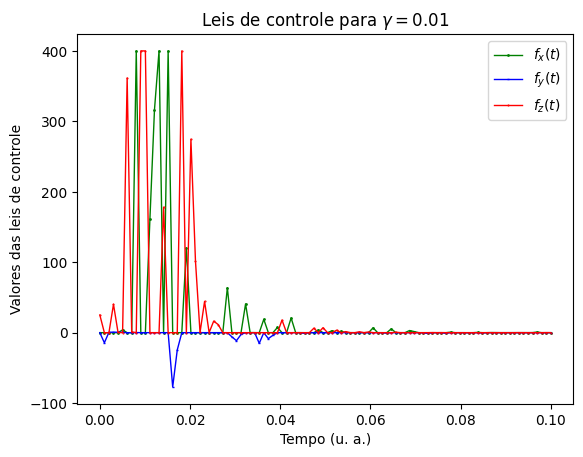

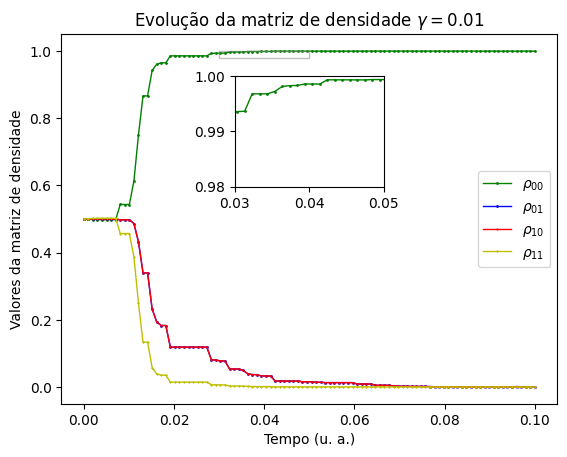

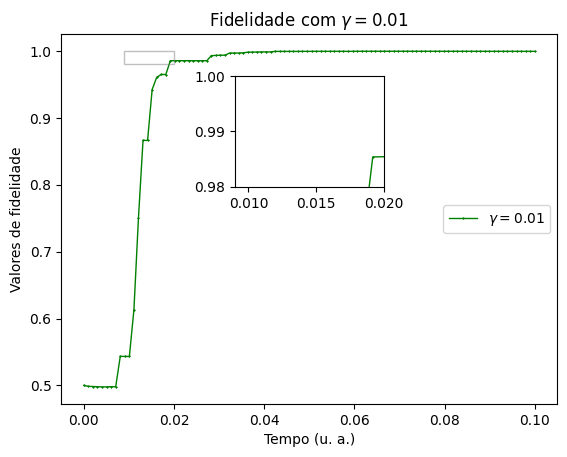

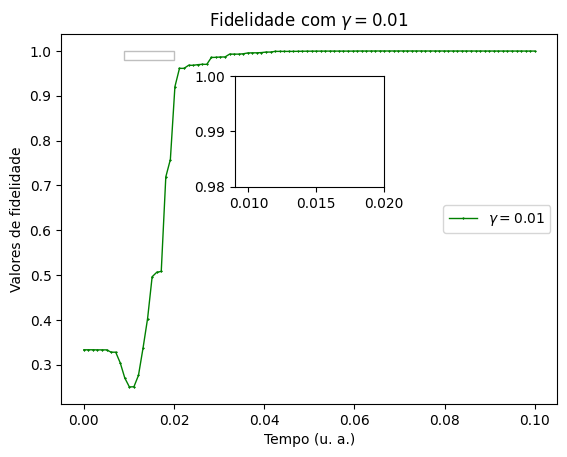

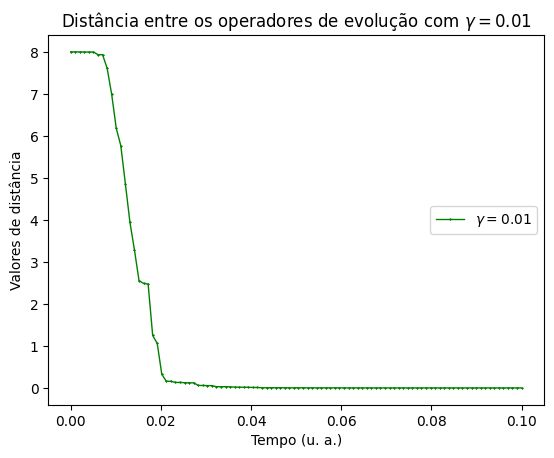

In [39]:
t = 100
lbda = 0.01
leis_controle(fx_vector,fy_vector,fz_vector,t,lbda)
densidade(rho_vector,t,lbda)
fidelidade(fid_vector,t,lbda)
fidelidade(fid_autores,t,lbda)
distance(distance_vector,t,lbda)